### 데이터 준비

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5205a7c1-bd5d-5da6-d586-03b449a85365)


In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
!gdown 1aJwrRilvlYHjlUVaAMT7E66YQQR5LB2A

Downloading...
From (uriginal): https://drive.google.com/uc?id=1aJwrRilvlYHjlUVaAMT7E66YQQR5LB2A
From (redirected): https://drive.google.com/uc?id=1aJwrRilvlYHjlUVaAMT7E66YQQR5LB2A&confirm=t&uuid=3abbda0c-7bcf-4bd7-8a4d-a84160548f44
To: /content/model_3_30.pth
100% 140M/140M [00:05<00:00, 25.0MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=13EMmfsyjrEbtisVuPOl1VUuJnjI7-4Ez

Downloading...
From (uriginal): https://drive.google.com/uc?id=13EMmfsyjrEbtisVuPOl1VUuJnjI7-4Ez
From (redirected): https://drive.google.com/uc?id=13EMmfsyjrEbtisVuPOl1VUuJnjI7-4Ez&confirm=t&uuid=224f28c7-4bec-4d06-8bd8-857c9d1d1271
To: /content/open.zip
100% 19.2G/19.2G [03:43<00:00, 85.9MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1KbD2iQftuJenERkFNcHBWjJmlxk-_HW3

Downloading...
From (uriginal): https://drive.google.com/uc?id=1KbD2iQftuJenERkFNcHBWjJmlxk-_HW3
From (redirected): https://drive.google.com/uc?id=1KbD2iQftuJenERkFNcHBWjJmlxk-_HW3&confirm=t&uuid=2e1c48e6-bb6e-4be1-bca0-69085a5af52d
To: /content/open.zip
100% 19.2G/19.2G [03:24<00:00, 94.0MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1HMy8IFlOx_uWgBABUEUc5m1TVnRWScjB

Downloading...
From (uriginal): https://drive.google.com/uc?id=1HMy8IFlOx_uWgBABUEUc5m1TVnRWScjB
From (redirected): https://drive.google.com/uc?id=1HMy8IFlOx_uWgBABUEUc5m1TVnRWScjB&confirm=t&uuid=fa9f6721-343a-4a28-a139-613bca686fed
To: /content/open.zip
100% 19.2G/19.2G [02:46<00:00, 115MB/s]


In [ ]:
!unzip -qq "open.zip"

### Import

In [ ]:
import os
import gc
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import sigmoid_focal_loss

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import files

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Utils

In [ ]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

### Custom Dataset


In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

### Define Model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, middle_channels):
        super(AttentionBlock, self).__init__()
        self.w_g = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=1),
            nn.BatchNorm2d(middle_channels),
        )
        self.w_x = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=1),
            nn.BatchNorm2d(middle_channels),
        )
        self.psi = nn.Sequential(
            nn.Conv2d(middle_channels, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g = self.w_g(g)
        x_ = self.w_g(x)
        psi = self.relu(g + x_)
        psi = self.psi(psi)
        return x * psi

In [ ]:
class AttentionUNet(nn.Module):
    def __init__(self):
        super(AttentionUNet, self).__init__()

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = ConvBlock(3, 64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.conv5 = ConvBlock(512, 1024)

        self.up5 = UpConv(1024, 512)
        self.attn5 = AttentionBlock(512, 256)
        self.up_conv5 = ConvBlock(1024, 512)

        self.up4 = UpConv(512, 256)
        self.attn4 = AttentionBlock(256, 128)
        self.up_conv4 = ConvBlock(512, 256)

        self.up3 = UpConv(256, 128)
        self.attn3 = AttentionBlock(128, 64)
        self.up_conv3 = ConvBlock(256, 128)

        self.up2 = UpConv(128, 64)
        self.attn2 = AttentionBlock(64, 32)
        self.up_conv2 = ConvBlock(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)

        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)

        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)

        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)

        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)

        d5 = self.up5(x5)
        x4 = self.attn5(d5, x4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.up_conv5(d5)

        d4 = self.up4(d5)
        x3 = self.attn4(d4, x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.up_conv4(d4)

        d3 = self.up3(d4)
        x2 = self.attn3(d3, x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.up_conv3(d3)

        d2 = self.up2(d3)
        x1 = self.attn2(d2, x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.up_conv2(d2)

        d1 = self.conv_last(d2)

        return d1

### Model Train

In [ ]:
gc.collect()
torch.cuda.empty_cache()

transform = A.Compose(
    [
        A.RandomCrop(224, 224),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_idx = [3, 5, 7, 9]

version = 3
epoch = 30
# model = AttentionUNet().to(device)
model = torch.load(f'./model_{version}_{epoch}.pth')

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 447/447 [06:15<00:00,  1.19it/s]


Epoch 12, Loss: 0.08747985713200548


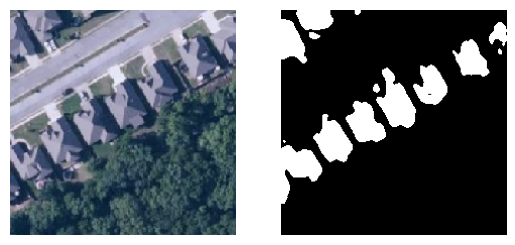

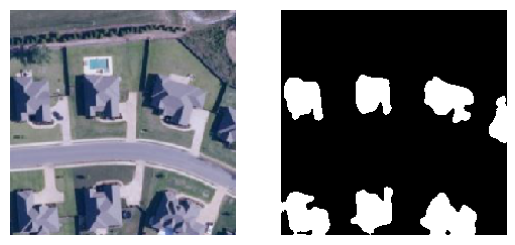

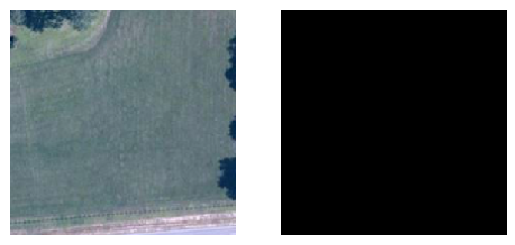

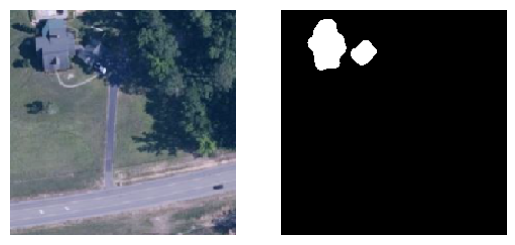

100%|██████████| 447/447 [06:14<00:00,  1.19it/s]


Epoch 12, Loss: 0.08505703036733789


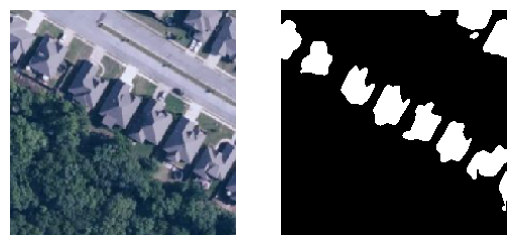

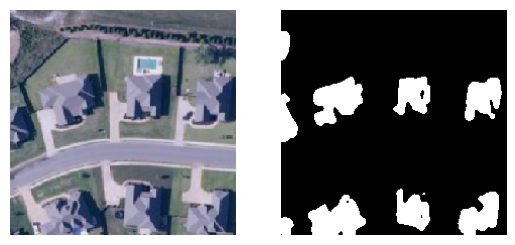

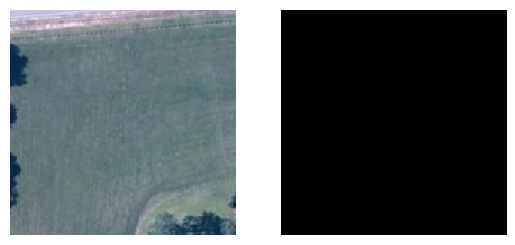

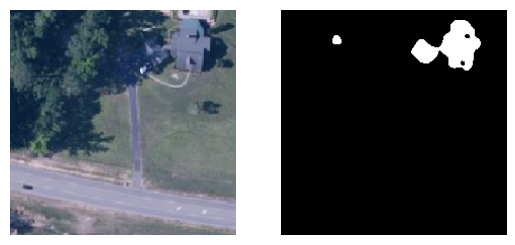

100%|██████████| 447/447 [06:15<00:00,  1.19it/s]


Epoch 12, Loss: 0.0847552891912343


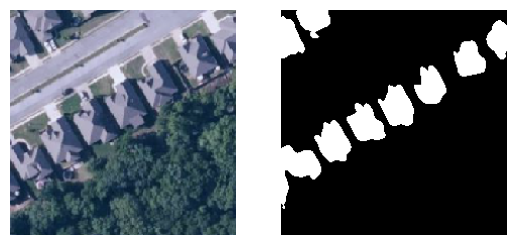

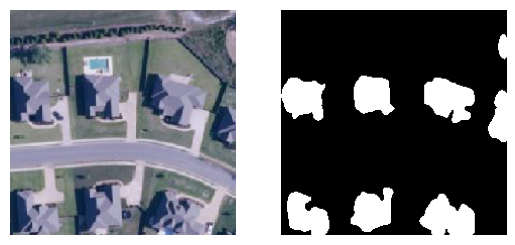

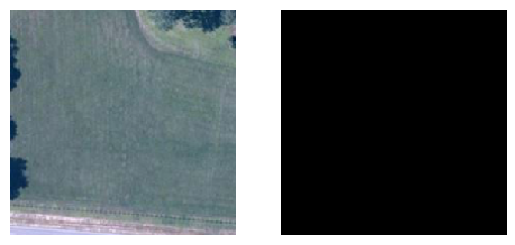

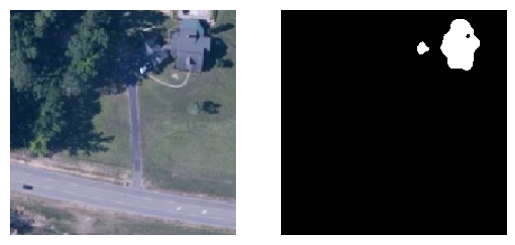

100%|██████████| 447/447 [06:16<00:00,  1.19it/s]


Epoch 12, Loss: 0.08143441247393354


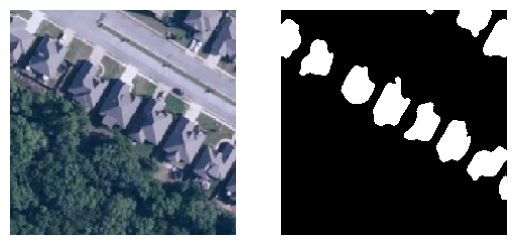

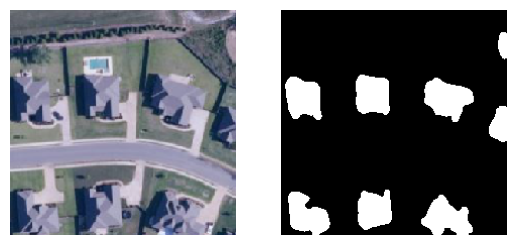

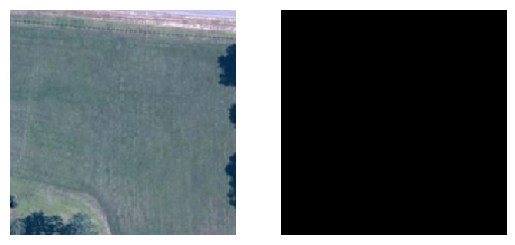

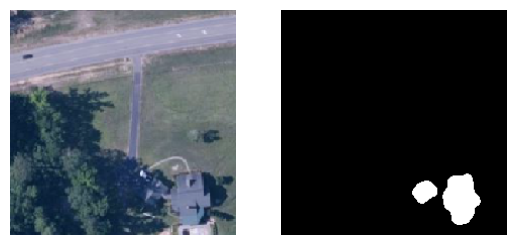

  1%|          | 5/447 [00:05<06:54,  1.07it/s]

In [ ]:
epoch += 1
while epoch <= 100:
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')
    with torch.no_grad():
        model.eval()
        for i in test_idx:
            image = test_dataset[i]
            input_image = image.to(device)
            mask = model(input_image.float().to(device).unsqueeze(0))[0]
            mask = torch.sigmoid(mask).cpu().numpy()
            mask = np.squeeze(mask, axis=0)
            plt.figure()
            plt.subplot(1, 2, 1)
            image = (image - image.min()) / (image.max() - image.min())
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            plt.show()

    if epoch % 10 == 0:
        torch.save(model, f'./model_{version}_{epoch}.pth')
        files.download(f'./model_{version}_{epoch}.pth')

### Inference

In [ ]:
transform = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 3790/3790 [18:01<00:00,  3.51it/s]


### Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

submit.to_csv(f'./submit_{version}_{epoch}.csv', index=False)
files.download(f'./submit_{version}_{epoch}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Test Model

In [ ]:
transform = A.Compose(
    [
        A.RandomCrop(224, 224),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

model1 = torch.load(f'./model_1_20.pth')
model2 = torch.load(f'./model_3_10.pth')

with torch.no_grad():
    model1.eval()
    model2.eval()
    for images, grounds in dataloader:
        input_images = images.float().to(device)
        outputs1 = model1(input_images)
        outputs2 = model2(input_images)

        for image, ground, mask1, mask2 in zip(images, grounds, outputs1, outputs2):
            mask1 = torch.sigmoid(mask1).cpu().numpy()
            mask1 = np.squeeze(mask1, axis=0)
            mask2 = torch.sigmoid(mask2).cpu().numpy()
            mask2 = np.squeeze(mask2, axis=0)

            plt.figure()
            plt.subplot(1, 4, 1)
            image = (image - image.min()) / (image.max() - image.min())
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            plt.subplot(1, 4, 2)
            plt.imshow(ground, cmap='gray')
            plt.axis('off')
            plt.subplot(1, 4, 3)
            plt.imshow(mask1, cmap='gray')
            plt.axis('off')
            plt.subplot(1, 4, 4)
            plt.imshow(mask2, cmap='gray')
            plt.axis('off')
            plt.show()